In [ ]:
!pip install kaggle

In [ ]:
!cp '/content/kaggle (2).json' /root/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c cian-datafest-2019

 69% 21.0M/30.5M [00:00<00:00, 50.0MB/s]
100% 30.5M/30.5M [00:00<00:00, 77.1MB/s]
 90% 85.0M/94.4M [00:01<00:00, 79.1MB/s]
100% 94.4M/94.4M [00:01<00:00, 86.1MB/s]
 92% 57.0M/62.0M [00:00<00:00, 69.1MB/s]
100% 62.0M/62.0M [00:00<00:00, 90.5MB/s]


In [ ]:
# !unzip /content/cian_datafest.zip
# !unzip /content/test.zip
# !unzip /content/train.zip

In [ ]:
import numpy as np
import scipy 
import pandas as pd
import PIL
import matplotlib.pyplot as plt

1.Data reader (jpeg -> numpy)
2. List of features
- Lighting (convert rgb2lab, component L (mean,variance,quantiles)
- Vertical and Horizontal lines (convolution filters, or histogramm + peaks)
- color histogramm
- HOG (historgamm of oriented gradients)
- pixel variation (statistics)
3. Baseline model - LogosticRegression/ GLM
4. Feature Selection
5. Improve Baseline (SVM, NB)

In [ ]:
import glob

indoor = [filename for filename in glob.glob('/content/datafest/indoor/*.jpg')]
outdoor = [filename for filename in glob.glob('/content/datafest/outdoor/*.jpg')]

In [ ]:
from PIL import ImageCms, ImageOps

def read_img(path,transform=False,is_grayscale=False):
  img = PIL.Image.open(path).convert('RGB')

  if transform:
    srgb_profile = ImageCms.createProfile("sRGB")
    lab_profile  = ImageCms.createProfile("LAB")
    rgb2lab_transform = ImageCms.buildTransformFromOpenProfiles(srgb_profile, lab_profile, "RGB", "LAB")
    img = ImageCms.applyTransform(img, rgb2lab_transform)
  
  if is_grayscale:
    img = ImageOps.grayscale(img)
  return np.array(img)

In [ ]:
def rgb2lab(inputColor):
	RGB=[0,0,0]
	for i in range(0,3):
		RGB[i]=inputColor[i]/255.0

	X=RGB[0]*0.4124+RGB[1]*0.3576+RGB[2]*0.1805
	Y=RGB[0]*0.2126+RGB[1]*0.7152+RGB[2]*0.0722
	Z=RGB[0]*0.0193+RGB[1]*0.1192+RGB[2]*0.9505
	XYZ=[X,Y,Z]
	XYZ[0]/=95.045/100
	XYZ[1]/=100.0/100
	XYZ[2]/=108.875/100

	L=0
	for i in range(0,3):
		v=XYZ[i]
		if v>0.008856:
			v=pow(v,1.0/3)
			if i==1:
				L=116.0*v-16.0
		else:
			v*=7.787
			v+=16.0/116
			if i==1:
				L=903.3*XYZ[i]
		XYZ[i]=v

	a=500.0*(XYZ[0]-XYZ[1])
	b=200.0*(XYZ[1]-XYZ[2])
	Lab=[int(L),int(a),int(b)]
	return Lab

In [ ]:
new_img = np.apply_along_axis(rgb2lab, 2, img)

In [ ]:
# Get Features for Lighting
from scipy.stats import moment, describe

L = new_img[:,:,0]
moments = [moment(L.flatten(),moment=i) for i in range(3,6)]

def describe_sp(data):
 
  descr_ = describe(data.flatten())
  return [descr_.minmax[0],descr_.minmax[1],descr_.mean,descr_.variance,descr_.skewness,descr.kurtosis]

stat_features = describe_sp(L)

In [ ]:
moments

[0.0,
 147.57572899974804,
 -2049.6462062263167,
 95805.52148096928,
 -3489807.580068959]

In [ ]:
stat_features

[18,
 100,
 85.45301587301587,
 147.59915743743653,
 -1.1432902429857805,
 1.399067892421634]

In [ ]:
gray_scal = read_img(indoor[250],is_grayscale=True)
gray_scal.shape

(100, 63)

In [ ]:
#Vertical and Horizontal lines
from scipy.ndimage import convolve

p = np.array([[0.0376593171958126, 0.249153396177344, 0.426374573253687,
               0.249153396177344, 0.0376593171958126]])
d1 = np.array([[0.109603762960254, 0.276690988455557, 0, -0.276690988455557,
                -0.109603762960254]])
HFARID_WEIGHTS = d1.T * p
VFARID_WEIGHTS = np.copy(HFARID_WEIGHTS.T)

image = img.astype('float')
result_h = convolve(gray_scal, HFARID_WEIGHTS)
result_v = convolve(gray_scal, VFARID_WEIGHTS)

h_features = describe_sp(result_h)[2:]
v_features = describe_sp(result_v)[2:]

In [ ]:
h_features

[139.8020634920635, 15391.8828660382, -0.20422595952425568, 1.399067892421634]

In [ ]:
v_features

[70.99571428571429, 12166.588805252535, 1.0070607769321784, 1.399067892421634]

(array([[ 0.,  1.,  6.,  8., 25.,  9., 11.,  2.,  9., 29.],
        [ 1.,  1.,  4.,  7.,  9., 22., 16.,  2.,  9., 29.],
        [ 1.,  1.,  1.,  8., 10., 12., 20.,  9.,  9., 29.],
        [ 0.,  2.,  1.,  9.,  9., 14., 17.,  9., 10., 29.],
        [ 0.,  3.,  1.,  9.,  8., 13., 18., 10.,  9., 29.],
        [ 0.,  2.,  1.,  9.,  8.,  8., 23., 11.,  8., 30.],
        [ 0.,  2.,  1.,  6., 14.,  2., 26., 10.,  9., 30.],
        [ 0.,  2.,  1., 10.,  8.,  8., 24.,  7., 10., 30.],
        [ 0.,  2.,  1.,  6., 11., 14., 15., 12., 12., 27.],
        [ 0.,  1.,  3.,  5., 14., 11., 15., 12.,  6., 33.],
        [ 0.,  1.,  2.,  6., 12., 12., 16., 12.,  7., 32.],
        [ 0.,  1.,  3.,  7.,  9., 11., 18., 13.,  8., 30.],
        [ 0.,  1.,  5.,  4., 10., 10., 18., 14.,  7., 31.],
        [ 0.,  1.,  5.,  4.,  8., 11., 22., 11.,  6., 32.],
        [ 0.,  0.,  5.,  4., 12.,  7., 25., 10.,  6., 31.],
        [ 0.,  1.,  6.,  2., 11.,  7., 25., 25., 21.,  2.],
        [ 0.,  2.,  6.,  5., 38., 10., 1

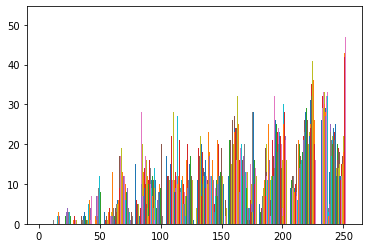

In [ ]:
#
plt.hist(img[:,:,0], bins=10)
plt.hist(img[:,:,1], bins=10)
plt.hist(img[:,:,2], bins=10)

In [ ]:
#color histogramm

r = np.histogram(img[:,:,0], bins=20)
g = np.histogram(img[:,:,1], bins=20)
b = np.histogram(img[:,:,2], bins=20)

hist_ = sum([r[0],g[0],b[0]])/3. 

In [ ]:
hist_

array([  9.        ,  18.33333333,  37.33333333,  49.        ,
        78.33333333, 161.66666667, 216.66666667, 228.66666667,
       278.        , 298.33333333, 293.66666667, 366.        ,
       422.        , 393.        , 366.33333333, 536.        ,
       543.66666667, 645.66666667, 567.33333333, 791.        ])

In [ ]:
#uses a [-1 0 1 kernel]
def create_grad_array(image_array):
	# image_array = Image.fromarray(image_array)
	# if not image_array.size == im_size:
	# 	image_array = image_array.resize(im_size, resample=Image.BICUBIC)
	
	# image_array = np.asarray(image_array,dtype=float)
	
	# gamma correction
	image_array = (image_array)**2.5

	# local contrast normalisation
	image_array = (image_array-np.mean(image_array))/np.std(image_array)
	max_h = image_array.shape[0]
	max_w = image_array.shape[1]


	grad = np.zeros([max_h, max_w])
	mag = np.zeros([max_h, max_w])
	for h,row in enumerate(image_array):
		for w, val in enumerate(row):
			if h-1>=0 and w-1>=0 and h+1<max_h and w+1<max_w:
				dy = image_array[h+1][w]-image_array[h-1][w]
				dx = row[w+1]-row[w-1]+0.0001
				grad[h][w] = np.arctan(dy/dx)*(180/np.pi)
				if grad[h][w]<0:
					grad[h][w] += 180
				mag[h][w] = np.sqrt(dy*dy+dx*dx)
	
	return grad,mag


def calculate_histogram(array,weights):
	bins_range = (0, 180)
	bins = bin_num
	hist,_ = np.histogram(array,bins=bins,range=bins_range,weights=weights)

	return hist

def create_hog_features(grad_array,mag_array):
	max_h = int(((grad_array.shape[0]-cell[0])/incr[0])+1)
	max_w = int(((grad_array.shape[1]-cell[1])/incr[1])+1)
	cell_array = []
	w = 0
	h = 0
	i = 0
	j = 0

	#Creating 8X8 cells
	while i<max_h:
		w = 0
		j = 0

		while j<max_w:
			for_hist = grad_array[h:h+cell[0],w:w+cell[1]]
			for_wght = mag_array[h:h+cell[0],w:w+cell[1]]
			
			val = calculate_histogram(for_hist,for_wght)
			cell_array.append(val)
			j += 1
			w += incr[1]

		i += 1
		h += incr[0]

	cell_array = np.reshape(cell_array,(max_h, max_w, bin_num))
	#normalising blocks of cells
	block = [2,2]
	#here increment is 1

	max_h = int((max_h-block[0])+1)
	max_w = int((max_w-block[1])+1)
	block_list = []
	w = 0
	h = 0
	i = 0
	j = 0

	while i<max_h:
		w = 0
		j = 0

		while j<max_w:
			for_norm = cell_array[h:h+block[0],w:w+block[1]]
			mag = np.linalg.norm(for_norm)
			arr_list = (for_norm/mag).flatten().tolist()
			block_list += arr_list
			j += 1
			w += 1

		i += 1
		h += 1

	#returns a vextor array list of 288 elements
	return block_list

#image_array must be an array
#returns a 288 features vector from image array
def apply_hog(image_array):
	gradient,magnitude = create_grad_array(image_array)
	hog_features = create_hog_features(gradient,magnitude)
	hog_features = np.asarray(hog_features,dtype=float)
	hog_features = np.expand_dims(hog_features,axis=0)

	return hog_features

In [ ]:
#HOG (historgamm of oriented gradients)

cell = [8, 8]
incr = [8,8]
bin_num = 8

hog_features = apply_hog(gray_scal)

In [ ]:
hog_features.shape

(1, 2112)

In [ ]:
img = read_img(indoor[250],transform=False)

In [ ]:
img.shape

(100, 63, 3)

In [ ]:
from skimage import io, color

img = io.imread(indoor[250])
img = color.rgb2lab(img)

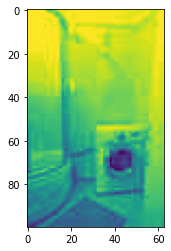

In [ ]:
plt.imshow(img[:,:,0])

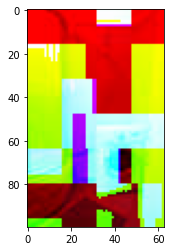

In [ ]:
%matplotlib inline

plt.imshow(rnd_img)